## Requirements

A [pip requirements file](https://pip.pypa.io/en/stable/user_guide/#requirements-files) can be found at: [/sashimdig/requirements.txt](../requirements.txt)

Notable requirements

|package    |version |
|----       |-----   |
|tensorflow | 0.10.0 |
| tflearn   | 0.2.1  |


----
### [TFLearn installation instructions](http://tflearn.org/installation/)
Must install older tensorflow version 0.10 (NOT the latest 1.0) to work w/ `tflearn`

```
# Mac OS X, CPU only, Python 3.4 or 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.10.0-py3-none-any.whl

# Mac OS X, GPU enabled, Python 3.4 or 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/gpu/tensorflow-0.10.0-py3-none-any.whl

sudo -H pip3 install --upgrade $TF_BINARY_URL --ignore-installed
```

In [13]:
%matplotlib inline
import numpy             as np
import pandas            as pd
import matplotlib
import seaborn           as sns
import matplotlib.pyplot as plt
import os
from   os      import getcwd
from   os      import listdir
from   os.path import isfile, join, isdir

import skimage
from   skimage import measure
from   skimage import io

from   PIL     import Image

from   sklearn.model_selection    import train_test_split
from   sklearn.metrics            import log_loss
from   sklearn.preprocessing      import LabelEncoder
from   skimage.transform          import resize

import tensorflow as tf
import tflearn
from   tflearn.data_utils         import shuffle
from   tflearn.layers.core        import input_data, dropout, fully_connected
from   tflearn.layers.conv        import conv_2d, max_pool_2d
from   tflearn.layers.normalization import batch_normalization
from   tflearn.layers.estimator   import regression
from   tflearn.data_preprocessing import ImagePreprocessing
from   tflearn.data_augmentation  import ImageAugmentation

In [14]:
def get_paths(foldNames):
  
    paths = dict.fromkeys(foldNames)

    for idx,g in enumerate(foldNames):
        fileNames = [f for f in listdir(join(trainPath,g)) if isfile(join(trainPath,g, f))]
        for i,f in enumerate(fileNames):
            fileNames[i] = join(trainPath,g,f)     
        paths[g] = fileNames
        
    return paths

def read_image(src):
    """Read and resize individual images"""
    im = io.imread(src)
    im = resize(im, (ROWS, COLS))
    return im


# Setup

In [15]:
trainPath      = '../data/raw/train'
testPath       = '../data/raw/test_stg1'
rawdataPath    = '../data/raw'

fish_classes   = [f for f in listdir(trainPath) if isdir(join(trainPath, f))]
groupData      = pd.DataFrame ({'group': fish_classes})
fish_paths     = get_paths(fish_classes)

# Model Parameters

In [16]:
subsample_amnt  = 50  # len(files) = 3777
downsample_amnt = 2
ROWS            = 128 # int(720  / downsample_amnt)
COLS            = 128 # int(1280 / downsample_amnt)
CHANNELS        = 3
NUM_CATEGORIES  = len(fish_classes)

# Build x and y arrays

In [17]:
%%time

for idx,fish in enumerate(fish_classes):
    groupData.ix[idx,'num files'] = int(len(fish_paths[fish]))
    
files = []
Y_all = []

for fish in fish_classes:
    fish_files = fish_paths[fish]
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    Y_all.extend(y_fish)
  
Y_all = np.array(Y_all) 
print('Y_all: Raw')
print('Shape:', Y_all.shape)
print(Y_all, '\n\n')

# One Hot Encoding Labels
#    Transform the categorical array Y_all into matrix of the same height, 
#    but with a boolean column for each category.
Y_all = LabelEncoder().fit_transform(Y_all)
Y_all = tflearn.data_utils.to_categorical(Y_all, NUM_CATEGORIES)
print('Y_all: One Hot Encoded')
print('Shape:', Y_all.shape)
print(Y_all, '\n\n')


Y_all: Raw
Shape: (3777,)
['ALB' 'ALB' 'ALB' ..., 'YFT' 'YFT' 'YFT'] 


Y_all: One Hot Encoded
Shape: (3777, 8)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]] 


CPU times: user 12.3 ms, sys: 1.77 ms, total: 14 ms
Wall time: 13 ms


## Sub-sample the training set

In [ ]:
if isinstance(subsample_amnt, int):
    from sklearn.utils import resample
    files, Y_all = resample(files, Y_all, 
                            n_samples = subsample_amnt, 
                            replace   = False)

## Load all training images into `X_all`

In [ ]:
%%time

X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS))

for i, f in enumerate(files): 
    im        = read_image(f)
    X_all[i]  = im
    if i%500 == 0: print('Processed {} of {}'.format(i, len(files)))

        


### View resampled image

### Test: Ensure that loaded images are correctly stored in `X_all`

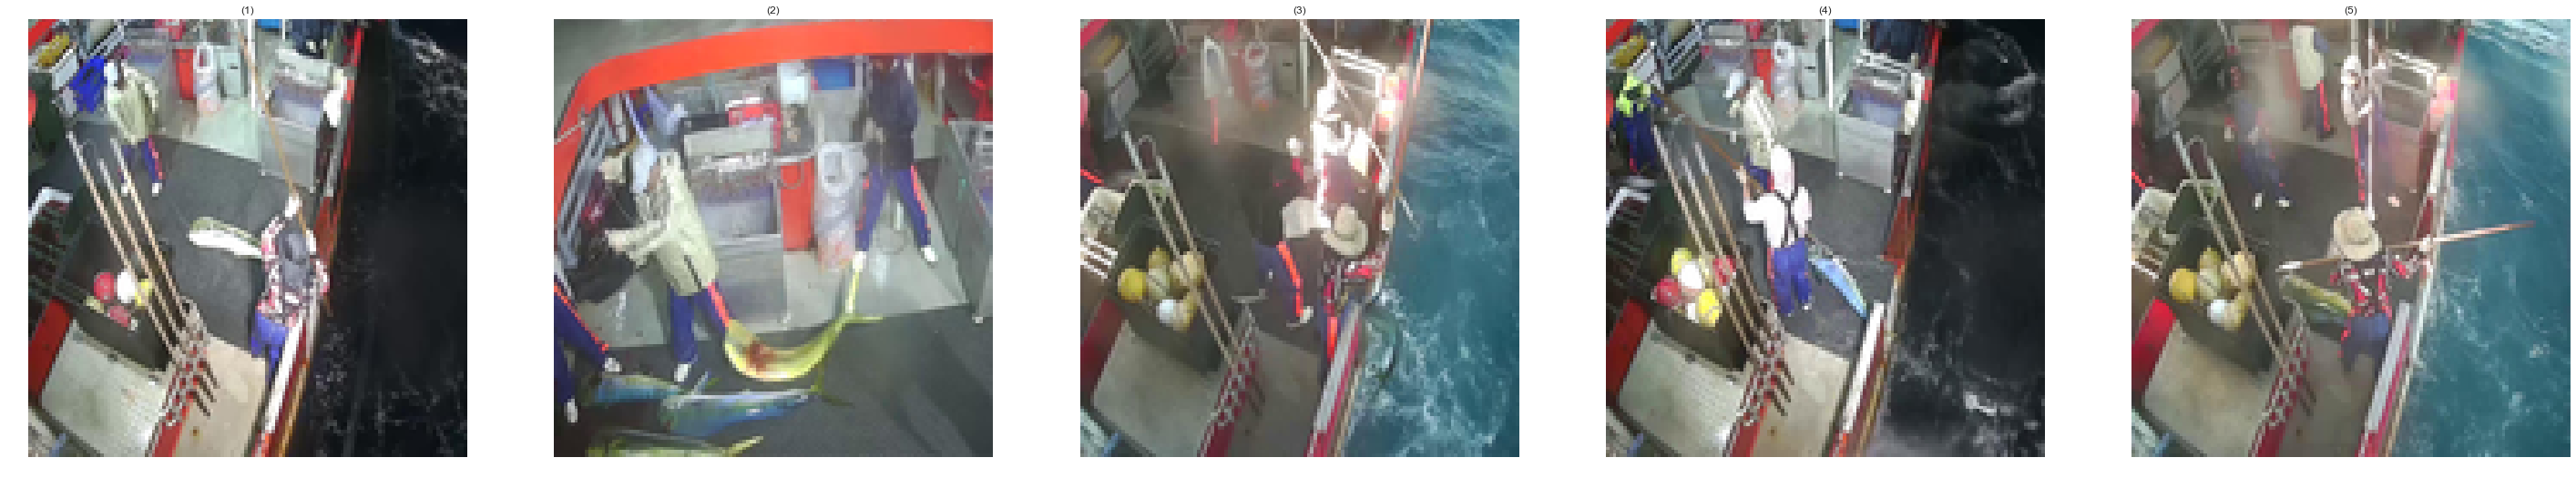

In [19]:
def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(10,10))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        plt.imshow(image, cmap='gray', interpolation='nearest')
        plt.axis('off')
        a.set_title(title)
        #         print(submission.iloc[jImage,:])
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

    

# Show 5 images randomly sample from `X_all`
num_images = 5
start_idx  = np.random.randint(0,len(X_all)-num_images)
end_idx    = start_idx + num_images
show_images(images=X_all[start_idx:end_idx])


# # Test image with `im`
# show_images(images=[X_all[i], 
#                     read_image(f), 
#                     X_all[i]-im], 
#             titles=['X_all',
#                     'read_image(f)', 
#                     'X_all[i]-read_image(f)'])

# Training data: `Y_all`, `X_train`, `Y_train`
* Split data


In [ ]:
%%time



# test_size: between 0 and 1. proportion of the dataset to include in the test split
# random_state: Pseudo-random number generator state used for random sampling. How to shoose this?
# stratify: this is ensuring that the split datasets are balanced, i.e. contains the same 
# percentage of classes

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, 
                                                      test_size    = 0.2, 
                                                      random_state = 23, 
                                                      stratify     = Y_all)

# TFLEARN

## Define the model


In [ ]:
# %%time

# def dnn_test1():
#     #needed to run this tensorflow operation in order to build the network and subsequently 
#     #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
#     #errors. Could also get around this issue by restarting kernel, but that's annoying.
#     with tf.Graph().as_default():
    
    
# #         # Real-time data preprocessing
# #         img_prep = ImagePreprocessing()
# #         img_prep.add_featurewise_zero_center()
        
        
# #         # Convolutional network building
# #         network = input_data(shape=[None, ROWS, COLS, CHANNELS], 
# #                             data_preprocessing=img_prep)

#         # input layer
#         network = input_data(shape=[None, ROWS, COLS, CHANNELS])
        
#         # hidden layers
#         network = conv_2d(network, 32, 3, activation='relu', regularizer='L2')
#         network = max_pool_2d(network, 2)
#         network = conv_2d(network, 64, 3, activation='relu', regularizer='L2')
#         network = conv_2d(network, 64, 3, activation='relu', regularizer='L2')
#         network = max_pool_2d(network, 2)
#         network = fully_connected(network, 512, activation='relu', regularizer='L2')
#         network = dropout(network, 0.5)
        
        
#         # output layer
#         network = fully_connected(network, NUM_CATEGORIES, activation='softmax', regularizer='L2')
#         network = regression(network, 
#                              loss='categorical_crossentropy',
#                              learning_rate=0.01)
#         return tflearn.DNN(network, 
#                            tensorboard_verbose=0)

# # Define model
# model = dnn_test1()

# # Start training (apply gradient descent algorithm). Will want to specify multiple epochs 
# # typically unless just testing


# # Train using classifier
# model.fit(X_train, Y_train, 
#           n_epoch        = 20, 
#           shuffle        = True, 
#           validation_set = (X_valid, Y_valid),
#           show_metric    = True, 
#           batch_size     = 96)

### Padding
- ['Same' vs 'Valid' Padding | StackOverflow](http://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t)


In [28]:
conv_2d?

In [29]:
tflearn.DNN?

In [27]:
def dnn_test():
    #needed to run this tensorflow operation in order to build the network and subsequently 
    #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
    #errors. Could also get around this issue by restarting kernel, but that's annoying.
    with tf.Graph().as_default():
    
    
        # Real-time data preprocessing
        #         img_prep = ImagePreprocessing()
        #         img_prep.add_featurewise_zero_center()

        
        # Convolutional network building
        #         network = input_data(shape=[None, ROWS, COLS, CHANNELS], 
        #                             data_preprocessing=img_prep,
        #                             dtype=tf.float32)

        # input layer
        network = input_data(shape=[None, ROWS, COLS, CHANNELS])
        
        # hidden layers
        network = conv_2d(network, 
                          32, 3, 
                          activation='relu', regularizer='L2')
                          
        network = batch_normalization (network)
        network = conv_2d(network, 32, 3, 
                          activation='relu', regularizer='L2', padding='same',
                          weights_init='Xavier')
        network = batch_normalization (network)
        network = max_pool_2d(network, 2)

        network = conv_2d(network, 32, 3, activation='relu', regularizer='L2', padding='same')
        network = batch_normalization (network)
        network = conv_2d(network, 32, 3, activation='relu', regularizer='L2', padding='same')
        network = batch_normalization (network)
        network = max_pool_2d(network, 2)
        
        network = conv_2d(network, 32, 3, activation='relu', regularizer='L2', padding='same')
        network = batch_normalization (network)
        network = conv_2d(network, 32, 3, activation='relu', regularizer='L2', padding='same')
        network = batch_normalization (network)
        network = max_pool_2d(network, 2)
        
        
        network = fully_connected(network, 512, activation='relu', regularizer='L2')
        network = dropout(network, 0.5)
        
        
        # output layer
        network = fully_connected(network, NUM_CATEGORIES, activation='softmax', regularizer='L2')
        network = regression(network, 
                             loss          = 'categorical_crossentropy',
                             learning_rate = 0.01)
        return tflearn.DNN(network, 
                           tensorboard_verbose=0)

In [21]:
# Define model
model = dnn_test()

# Train using classifier
model.fit(X_train, Y_train, 
          n_epoch        = 2, 
          shuffle        = True, 
          validation_set = (X_valid, Y_valid),
          show_metric    = True, 
          batch_size     = 96)

Training Step: 63  | total loss: 12.97528 | time: 299.857s
| Adam | epoch: 002 | loss: 12.97528 - acc: 0.4303 -- iter: 2976/3021
Training Step: 64  | total loss: 12.70254 | time: 334.647s
| Adam | epoch: 002 | loss: 12.70254 - acc: 0.4429 | val_loss: 12.43389 - val_acc: 0.4590 -- iter: 3021/3021
--


## Predict & save to submission file

### Load Test Data

In [ ]:
%%time

# read in test photo set
test_files = [im for im in os.listdir(testPath)]
X_submit   = np.ndarray((len(test_files), ROWS, COLS, CHANNELS))


for i, im in enumerate(test_files): 
    X_submit[i] = read_image(join(testPath,im))


#model predict
test_preds1 = model.predict(X_submit)

In [ ]:
%%time
submissionPath = join(rawdataPath,'jfa-2.0-submission.csv')

submission = pd.DataFrame(test_preds1, columns=fish_classes)
submission.insert(0, 'image', test_files)
submission.to_csv(submissionPath, index=False) 
submission.head()

In [ ]:
def sample_prediction(jImage):
    im = read_image(join(testPath, submission.image[jImage]))
    plt.figure(figsize=(5, 5))
    plt.imshow(im, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    foo = submission.iloc[jImage,1:]
    print(foo.sort_values(ascending=False))


In [ ]:
num_samples = 20
for i in range(num_samples):
    sample_prediction(np.random.randint(low=0, high=1000))

## Visualization

Using [tensorboard & tflearn](http://tflearn.org/getting_started/#visualization) to visualize the loss and accuracy functions



In [ ]:
# %%bash

# tensorboard --logdir='/tmp/tflearn_logs'

----
## HDF5 sandbox

Using HDF5 with TFLearn to save the full dataset. HDF5 is a data model, library, and file format for storing and managing data. It can handle large dataset that could not fit totally in ram memory. Note that this example just give a quick compatibility demonstration. In practice, there is no so real need to use HDF5 for small dataset (e.g. CIFAR-10)

In [ ]:
def save_h5f(h5f_filename, X_all, Y_all, X_submit):
    """Create hdf5 dataset from fish numpy arrays"""
    import h5py

    h5f = h5py.File(fish_h5f_filename)

    h5f.create_dataset('fish_X_submit', data=X_submit)
    h5f.close()

def load_h5f(h5f_filename):
    """Load fish hdf5 data"""
    import h5py
    h5f = h5py.File(fish_h5f_filename)
    X_all    = h5f['X'][()]
    Y_all    = h5f['Y'][()]
    X_submit = h5f['fish_X_submit'][()]
    return X_all, Y_all, X_submit


In [ ]:
fish_h5f_filename = join(rawdataPath, 'fish_data.h5')

save_h5f(fish_h5f_filename, X_all, Y_all, X_submit)

In [ ]:
fish_h5f_filename = join(rawdataPath, 'fish_data.h5')

foo, bar, baz = load_h5f(fish_h5f_filename)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, 
                                                      test_size    =0.2, 
                                                      random_state =23, 
                                                      stratify     =Y_all)

## `build_hdf5_image_dataset`

In [ ]:
build_hdf5_image_dataset?

In [8]:
%%time

BUILD_HDF5_DATASET = False
IMAGE_SIZE         = 128
VALIDATION_SPLIT   = True
output_path        = join(rawdataPath, 'fish_dataset_{}x{}.h5'.format(IMAGE_SIZE, IMAGE_SIZE))
input_path         = join(rawdataPath, 'train')

if BUILD_HDF5_DATASET:
    # Build a HDF5 dataset (only required once)
    from tflearn.data_utils import build_hdf5_image_dataset


    build_hdf5_image_dataset(target_path        =input_path, 
                             image_shape        =(IMAGE_SIZE, IMAGE_SIZE), 
                             mode               ='folder', 
                             output_path        =output_path, 
                             categorical_labels =True, 
                             normalize          =True)

CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 22.2 µs


In [9]:
%%time

# Load HDF5 dataset
import h5py

h5f         = h5py.File(output_path, 'r')
X_all       = h5f['X'][()]
Y_all       = h5f['Y'][()]

# Split into 
if VALIDATION_SPLIT:
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, 
                                                          test_size    =0.2, 
                                                          random_state =23, 
                                                          stratify     =Y_all)


CPU times: user 217 ms, sys: 890 ms, total: 1.11 s
Wall time: 2.04 s


## Layer Visualization

In [23]:
import tflearn
import numpy as np
import matplotlib.pyplot as plt
import six


def display_convolutions(model, layer, padding=4, filename=''):
    if isinstance(layer, six.string_types):
        vars = tflearn.get_layer_variables_by_name(layer)
        variable = vars[0]
    else:
        variable = layer.W

    data = model.get_weights(variable)

    # N is the total number of convolutions
    N = data.shape[2] * data.shape[3]

    # Ensure the resulting image is square
    filters_per_row = int(np.ceil(np.sqrt(N)))
    # Assume the filters are square
    filter_size = data.shape[0]
    # Size of the result image including padding
    result_size = filters_per_row * (filter_size + padding) - padding
    # Initialize result image to all zeros
    result = np.zeros((result_size, result_size))

    # Tile the filters into the result image
    filter_x = 0
    filter_y = 0
    for n in range(data.shape[3]):
        for c in range(data.shape[2]):
            if filter_x == filters_per_row:
                filter_y += 1
                filter_x = 0
            for i in range(filter_size):
                for j in range(filter_size):
                    result[filter_y * (filter_size + padding) + i, filter_x * (filter_size + padding) + j] = \
                        data[i, j, c, n]
            filter_x += 1

    # Normalize image to 0-1
    min = result.min()
    max = result.max()
    result = (result - min) / (max - min)

    # Plot figure
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(result, cmap='gray', interpolation='nearest')

    # Save plot if filename is set
    if filename != '':
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()

In [24]:
model

In [ ]:
model.